In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (Conv2D, Layer, Concatenate, Layer, Multiply)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# from tensorflow.keras import backend as K
# K.clear_session() # to free up memory, if tf didn't done it automatically


In [2]:
# Path to store results of this test, test dataset, and trained keras model
res_path = r"D:\AJAY\Main-Project\Results\test"
test_dir = r"D:\AJAY\Main-Project\Dataset\Hockey\val"
model_path = r"D:\AJAY\Main-Project\Results\train\best_model.keras"

In [3]:
# Definition for Custom Object 'SpatialAttention'
class SpatialAttention(Layer):
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.conv2d = Conv2D(1, (7, 7), activation='sigmoid', padding='same')
        super(SpatialAttention, self).build(input_shape)

    def call(self, inputs):
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        concat = Concatenate(axis=-1)([max_pool, avg_pool])
        attention = self.conv2d(concat)
        return Multiply()([inputs, attention])
        # See the train.py file for the detailed comments of these codes

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super(SpatialAttention, self).get_config()
        return config


In [4]:
def load_and_preprocess_data(directory):
    X, y = [], []
    dirs = sorted(os.listdir(directory))
    one_hots = to_categorical(range(len(dirs)))

    for i, folder in enumerate(dirs):
        folder_path = os.path.join(directory, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            data = np.load(file_path, mmap_mode='r')
            data = np.float32(data)
            data = normalize(data[..., :3])
            data = uniform_sampling(data)

            X.append(data)
            y.append(one_hots[i])
    
    return np.array(X), np.array(y)

def normalize(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std

def uniform_sampling(video, target_frames=20):
    interval = int(np.ceil(len(video) / target_frames))
    sampled = [video[i] for i in range(0, len(video), interval)]
    if len(sampled) > target_frames:
        sampled = sampled[:target_frames]
    elif len(sampled) < target_frames:
        sampled += [video[-1]] * (target_frames - len(sampled))
    return np.array(sampled, dtype=np.float32)

In [5]:
model = load_model(model_path, custom_objects={'SpatialAttention': SpatialAttention}) # Load the model

In [6]:
with tf.device("CPU"): # if GPU shows OOM Error
    X_test, y_test = load_and_preprocess_data(test_dir)
    predictions = model.predict(X_test, batch_size=2)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

100/100 [==============================] - 62s 586ms/step


In [7]:
# metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

In [8]:
# Print results
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:\n', conf_matrix)

Accuracy: 0.89
Precision: 0.8977968176254589
Recall: 0.8899999999999999
F1 Score: 0.8894583458948849
Confusion Matrix:
 [[96  4]
 [18 82]]


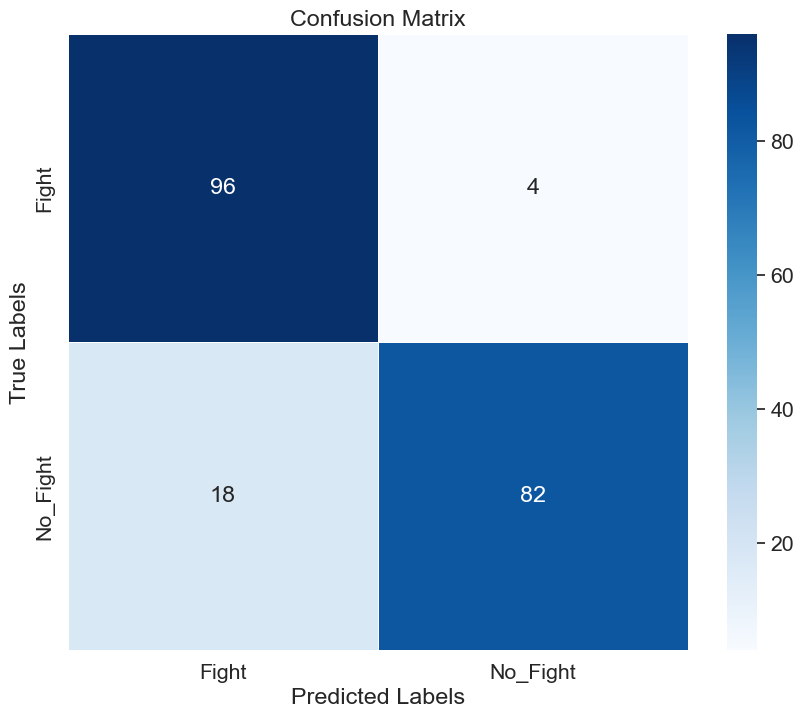

In [9]:
sns.set(font_scale=1.4)

# heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=True, linewidths=.5,
                 xticklabels=['Fight', 'No_Fight'], yticklabels=['Fight', 'No_Fight'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [10]:
csv_file = os.path.join(res_path, 'test_results.csv')

results = pd.DataFrame({
    'True Label': y_true,
    'Predicted Label': y_pred,
    'Pred Prob [Class 0, Class 1]': [[round(prob, 3) for prob in probs] for probs in predictions]
})

with open(csv_file, 'w') as file:
    file.write('Fight: 0, No_Fight: 1\n') # first line to show label names
results.to_csv(csv_file, mode='a', index=False, header=True)

print("Results and metrics saved to 'test_results.csv'")

Results and metrics saved to 'test_results.csv'


In [11]:
res_txt = os.path.join(res_path, 'test_metrics.txt')

# Convert metrics to percentage with two decimal place precision
accuracy_pct = round(accuracy * 100, 2)
precision_pct = round(precision * 100, 2)
recall_pct = round(recall * 100, 2)
f1_pct = round(f1 * 100, 2)

with open(res_txt, 'w') as file:
    file.write(f'Accuracy: {accuracy_pct}%\n\n')
    file.write(f'Precision: {precision_pct}%\n\n')
    file.write(f'Recall: {recall_pct}%\n\n')
    file.write(f'F1 Score: {f1_pct}%\n\n')
    file.write('Confusion Matrix:\n')
    for line in conf_matrix:
        file.write(f'{line}\n')

print(f"Results have been saved to test_metrics.txt")

Results have been saved to test_metrics.txt
